In [1]:
# load image in gray color

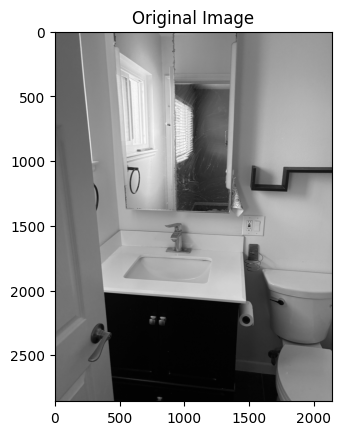

In [2]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# Load grayscale image
img = Image.open('IMG_6288.jpg').convert('L')  # Convert to grayscale
img_np = np.array(img)
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.show()

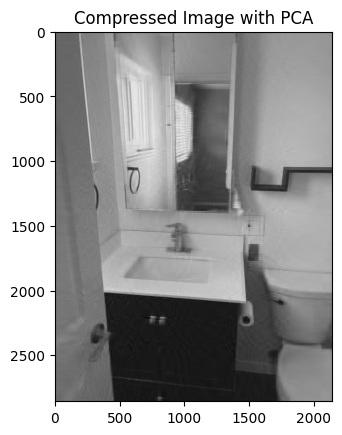

In [3]:
k = 50

# Fit PCA on rows
pca = PCA(n_components=k)
img_transformed = pca.fit_transform(img_np)
img_reconstructed = pca.inverse_transform(img_transformed)

plt.imshow(img_reconstructed, cmap='gray')
plt.title("Compressed Image with PCA")
plt.show()

In [4]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

# Load grayscale image
img = Image.open("IMG_6288.jpg").convert("L")
img_np = np.array(img)
m, n = img_np.shape 

# Memory size estimate
dtype_size = img_np.dtype.itemsize  # usually 1 for uint8, but PCA uses float64 by default
pca_dtype_size = np.dtype(np.float64).itemsize

size_transformed = img_transformed.size * pca_dtype_size
size_components = pca.components_.size * pca_dtype_size
total_size = size_transformed + size_components

print(f"Original Size: {img_np.size * dtype_size / 1024:.2f} KB")
print(f"Image PCA transformed Size: {size_transformed / 1024:.2f} KB")
print(f"PCA components Size: {size_components / 1024:.2f} KB")
print(f"PCA Compressed Size: {total_size / 1024:.2f} KB")


Original Size: 5974.17 KB
Image PCA transformed Size: 1115.62 KB
PCA components Size: 836.72 KB
PCA Compressed Size: 1952.34 KB


In [5]:
# load color image

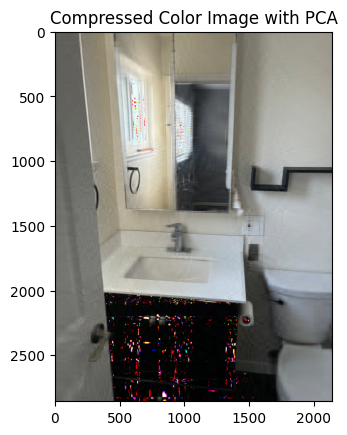

In [6]:
img = Image.open('IMG_6288.jpg')
img_np = np.array(img)

compressed_channels = []
size_transformed
for i in range(3):  # For R, G, B
    pca = PCA(n_components=k)
    channel = img_np[:, :, i]
    transformed = pca.fit_transform(channel)
    reconstructed = pca.inverse_transform(transformed)
    compressed_channels.append(reconstructed)

compressed_img = np.stack(compressed_channels, axis=2).astype(np.uint8)
plt.imshow(compressed_img)
plt.title("Compressed Color Image with PCA")
plt.show()

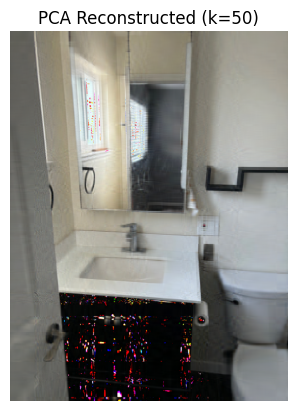

Original Size: 17922.52 KB
Image PCA transformed Size: 418.36 KB
PCA components Size: 313.77 KB
PCA Compressed Size: 5857.03 KB
Compression Ratio: 3.06


In [7]:
img = Image.open("IMG_6288.jpg").convert("RGB")
img_np = np.array(img)
h, w, c = img_np.shape  # (height, width, 3)

k = 50

# Store PCA compressed data
compressed_channels = []
pca_components = []
transformed_data = []

for i in range(3):  # for R, G, B
    channel = img_np[:, :, i]

    pca = PCA(n_components=k)
    transformed = pca.fit_transform(channel)
    reconstructed = pca.inverse_transform(transformed)

    compressed_channels.append(reconstructed)
    transformed_data.append(transformed)
    pca_components.append(pca.components_)

# Stack channels back
img_reconstructed = np.stack(compressed_channels, axis=2).astype(np.uint8)

# Show reconstructed image
plt.imshow(img_reconstructed)
plt.title(f"PCA Reconstructed (k={k})")
plt.axis('off')
plt.show()

# Calculate compressed size
dtype_size = np.dtype(np.float64).itemsize  # sklearn uses float64

# Size in bytes: (h * k + k * w) * 3 (for R, G, B)
total_transformed = sum(t.size for t in transformed_data)
total_components = sum(c.size for c in pca_components)
total_pca_bytes = (total_transformed + total_components) * dtype_size

# Original size in bytes (uint8)
original_bytes = img_np.size * img_np.itemsize

print(f"Original Size: {original_bytes / 1024:.2f} KB")
print(f"Image PCA transformed Size: {total_transformed / 1024:.2f} KB")
print(f"PCA components Size: {total_components / 1024:.2f} KB")
print(f"PCA Compressed Size: {total_pca_bytes / 1024:.2f} KB")
print(f"Compression Ratio: {original_bytes / total_pca_bytes:.2f}")

In [8]:
# measuremnt

In [9]:

import math

def rmse(img1, img2):
    
    total = 0
    for i in range(3):
        total += np.sum((img1[:, :, i] - img2[:, :, i]) ** 2)
    for i in range(3):
        total /= img1.shape[i]
    return math.sqrt(total)

import cv2

def psnr(img1, img2):
    return cv2.PSNR(img1, img2)
    

In [10]:
rmse(img_np,  img_reconstructed)

4.106759585645705

In [11]:
psnr(img_np,  img_reconstructed)

22.97531007964659

In [12]:
# compute metrics for 1000 samples from image net when reading image in RGB

In [13]:
import time
from skimage.metrics import structural_similarity as ssim

def pca_compress_rgb(img_file_path, k=10):

    start = time.perf_counter_ns()

    img = Image.open(img_file_path).convert("RGB")
    img_np = np.array(img)
    h, w, c = img_np.shape  # (height, width, 3)
    
    # Store PCA compressed data
    compressed_channels = []
    pca_components = []
    transformed_data = []
    
    for i in range(3):  # for R, G, B
        channel = img_np[:, :, i]
    
        pca = PCA(n_components=k)
        transformed = pca.fit_transform(channel)
        reconstructed = pca.inverse_transform(transformed)
    
        compressed_channels.append(reconstructed)
        transformed_data.append(transformed)
        pca_components.append(pca.components_)
    
    # Stack channels back
    img_reconstructed = np.stack(compressed_channels, axis=2).astype(np.uint8)

    end = time.perf_counter_ns()
    diff_ms = (end - start) / 1_000_000 

    # Calculate compressed size
    dtype_size = np.dtype(np.float64).itemsize  # sklearn uses float64
    
    # Size in bytes: (h * k + k * w) * 3 (for R, G, B)
    total_transformed = sum(t.size for t in transformed_data)
    total_components = sum(c.size for c in pca_components)
    total_pca_bytes = (total_transformed + total_components) * dtype_size
    
    # Original size in bytes (uint8)
    original_bytes = img_np.size * img_np.itemsize

    # compression ratio
    compression_ratio = original_bytes / total_pca_bytes

    # rmse
    rmse = 0
    for i in range(3):
        rmse += np.sum((img_np[:, :, i] - img_reconstructed[:, :, i]) ** 2)
    for i in range(3):
        rmse /= img_np.shape[i]
    rmse = math.sqrt(rmse)

    # psnr
    psnr = cv2.PSNR(img_np, img_reconstructed)

    # ssim
    _ssim = ssim(img_np, img_reconstructed, channel_axis=-1)
    
    return compression_ratio, rmse, psnr, _ssim, diff_ms

In [14]:
import os


def pca_compress_rgb_1000(k):
    
    directory = 'imagenet-sample-images'
    
    cnt = 1
    total_compression_ratio = 0
    total_rmse = 0
    total_psnr = 0
    total_ssim = 0
    total_ms = 0
    
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filepath[-4:] == 'JPEG':
            if cnt % 200 == 1: 
                print(f"processing file {filepath}: {cnt}")
            compression_ratio, rmse, psnr, ssim, ms = pca_compress_rgb(filepath, k)
            total_compression_ratio += compression_ratio
            total_rmse += rmse
            total_psnr += psnr
            total_ssim += ssim
            total_ms += ms
            cnt += 1

    avg_compression_ratio = total_compression_ratio / cnt
    avg_rmse = total_rmse / cnt
    avg_psnr = total_psnr / cnt
    avg_ssim = total_ssim / cnt
    avg_ms = total_ms / cnt
    
    print(f"Avg compression ratio: {avg_compression_ratio} when k={k}")
    print(f"Avg rmse: {avg_rmse} when k={k}")
    print(f"Avg psnr: {avg_psnr} dB when k={k}")
    print(f"Avg ssim: {avg_ssim} when k={k}")
    print(f"Avg processing time: {avg_ms} ms when k={k}")

    return avg_compression_ratio, avg_rmse, avg_psnr, avg_ssim, avg_ms

pca_compress_rgb_1000(10)

processing file imagenet-sample-images/n07615774_ice_lolly.JPEG: 1
processing file imagenet-sample-images/n02096294_Australian_terrier.JPEG: 201
processing file imagenet-sample-images/n01682714_American_chameleon.JPEG: 401
processing file imagenet-sample-images/n03535780_horizontal_bar.JPEG: 601
processing file imagenet-sample-images/n02071294_killer_whale.JPEG: 801
Avg compression ratio: 2.6376088118616776 when k=10
Avg rmse: 8.176578779576987 when k=10
Avg psnr: 18.11206918479429 dB when k=10
Avg ssim: 0.5320407446111706 when k=10
Avg processing time: 46.696755587412596 ms when k=10


(2.6376088118616776,
 8.176578779576987,
 18.11206918479429,
 np.float64(0.5320407446111706),
 46.696755587412596)

processing file imagenet-sample-images/n07615774_ice_lolly.JPEG: 1
processing file imagenet-sample-images/n02096294_Australian_terrier.JPEG: 201
processing file imagenet-sample-images/n01682714_American_chameleon.JPEG: 401
processing file imagenet-sample-images/n03535780_horizontal_bar.JPEG: 601
processing file imagenet-sample-images/n02071294_killer_whale.JPEG: 801
Avg compression ratio: 5.275217623723355 when k=5
Avg rmse: 8.721845692861079 when k=5
Avg psnr: 17.13617974566147 dB when k=5
Avg ssim: 0.47647370358764723 when k=5
Avg processing time: 46.91853831168828 ms when k=5
processing file imagenet-sample-images/n07615774_ice_lolly.JPEG: 1
processing file imagenet-sample-images/n02096294_Australian_terrier.JPEG: 201
processing file imagenet-sample-images/n01682714_American_chameleon.JPEG: 401
processing file imagenet-sample-images/n03535780_horizontal_bar.JPEG: 601
processing file imagenet-sample-images/n02071294_killer_whale.JPEG: 801
Avg compression ratio: 2.6376088118616776 whe

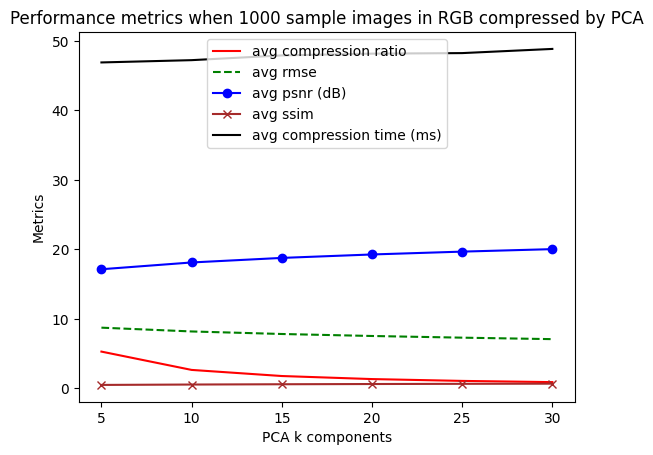

In [15]:

ks = [5, 10, 15, 20, 25, 30]
avg_compression_ratios = []
avg_rmses = []
avg_psnrs = []
avg_ssims = []
avg_mss = []

for k in ks:
    avg_compression_ratio, avg_rmse, avg_psnr, avg_ssim, avg_ms = pca_compress_rgb_1000(k)
    avg_compression_ratios.append(avg_compression_ratio)
    avg_rmses.append(avg_rmse)
    avg_psnrs.append(avg_psnr)
    avg_ssims.append(avg_ssim)
    avg_mss.append(avg_ms)

# Plotting multiple lines
plt.plot(ks, avg_compression_ratios, label='avg compression ratio', color='red')
plt.plot(ks, avg_rmses, label='avg rmse', color='green', linestyle='--')
plt.plot(ks, avg_psnrs, label='avg psnr (dB)', color='blue', marker='o')
plt.plot(ks, avg_ssims, label='avg ssim', color='brown', marker='x')
plt.plot(ks, avg_mss, label='avg compression time (ms)', color='black')

# Adding title and labels
plt.title('Performance metrics when 1000 sample images in RGB compressed by PCA')
plt.xlabel('PCA k components')
plt.ylabel('Metrics')

# Add legend
plt.legend()

# Show plot
plt.show()

In [16]:
# compute metrics for 1000 samples from image net when reading image in gray

In [20]:
import math
def pca_compress_gray(img_file_path, k=10):

    start = time.perf_counter_ns()

    img = Image.open(img_file_path).convert("L")
    img_np = np.array(img)
    
    # Store PCA compressed data
    compressed_channels = []
    pca_components = []
    transformed_data = []
    
    pca = PCA(n_components=k)
    img_transformed = pca.fit_transform(img_np)
    img_reconstructed = pca.inverse_transform(img_transformed)

    end = time.perf_counter_ns()
    diff_ms = (end - start) / 1_000_000 

    # Calculate compressed size
    dtype_size = np.dtype(np.float64).itemsize  # sklearn uses float64
    
    size_transformed = img_transformed.size * dtype_size
    size_components = pca.components_.size * dtype_size
    total_size = size_transformed + size_components

    # Original size in bytes (uint8)
    original_bytes = img_np.size * img_np.itemsize

    # compression ratio
    compression_ratio = original_bytes / total_size

    # rmse
    mse = np.mean((img_np - img_reconstructed) ** 2)
    rmse = math.sqrt(mse)
    
    # psnr
    max_pixel = 255.0  # Maximum pixel value for an 8-bit grayscale image
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    
    # ssim
    _ssim = ssim(img_np, img_reconstructed, data_range=255.0)
    
    return compression_ratio, rmse, psnr, _ssim, diff_ms

In [21]:

def pca_compress_gray_1000(k):
    
    directory = 'imagenet-sample-images'
    
    cnt = 1
    total_compression_ratio = 0
    total_rmse = 0
    total_psnr = 0
    total_ssim = 0
    total_ms = 0
    
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath) and filepath[-4:] == 'JPEG':
            if cnt % 200 == 1: 
                print(f"processing file {filepath}: {cnt}")
            compression_ratio, rmse, psnr, ssim, ms = pca_compress_gray(filepath, k)
            total_compression_ratio += compression_ratio
            total_rmse += rmse
            total_psnr += psnr
            total_ssim += ssim
            total_ms += ms
            cnt += 1

    avg_compression_ratio = total_compression_ratio / cnt
    avg_rmse = total_rmse / cnt
    avg_psnr = total_psnr / cnt
    avg_ssim = total_ssim / cnt
    avg_ms = total_ms / cnt
    
    print(f"Avg compression ratio: {avg_compression_ratio} when k={k}")
    print(f"Avg rmse: {avg_rmse} when k={k}")
    print(f"Avg psnr: {avg_psnr} dB when k={k}")
    print(f"Avg ssim: {avg_ssim} when k={k}")
    print(f"Avg processing time: {avg_ms} ms when k={k}")

    return avg_compression_ratio, avg_rmse, avg_psnr, avg_ssim, avg_ms

pca_compress_gray_1000(10)

processing file imagenet-sample-images/n07615774_ice_lolly.JPEG: 1
processing file imagenet-sample-images/n02096294_Australian_terrier.JPEG: 201
processing file imagenet-sample-images/n01682714_American_chameleon.JPEG: 401
processing file imagenet-sample-images/n03535780_horizontal_bar.JPEG: 601
processing file imagenet-sample-images/n02071294_killer_whale.JPEG: 801
Avg compression ratio: 2.6376088118616776 when k=10
Avg rmse: 20.6897254647624 when k=10
Avg psnr: 22.506273306853398 dB when k=10
Avg ssim: 0.5738521655544918 when k=10
Avg processing time: 16.815208325674337 ms when k=10


(2.6376088118616776,
 20.6897254647624,
 22.506273306853398,
 np.float64(0.5738521655544918),
 16.815208325674337)

processing file imagenet-sample-images/n07615774_ice_lolly.JPEG: 1
processing file imagenet-sample-images/n02096294_Australian_terrier.JPEG: 201
processing file imagenet-sample-images/n01682714_American_chameleon.JPEG: 401
processing file imagenet-sample-images/n03535780_horizontal_bar.JPEG: 601
processing file imagenet-sample-images/n02071294_killer_whale.JPEG: 801
Avg compression ratio: 5.275217623723355 when k=5
Avg rmse: 25.557853031115727 when k=5
Avg psnr: 20.51557199923042 dB when k=5
Avg ssim: 0.5102760221330156 when k=5
Avg processing time: 16.877590840159833 ms when k=5
processing file imagenet-sample-images/n07615774_ice_lolly.JPEG: 1
processing file imagenet-sample-images/n02096294_Australian_terrier.JPEG: 201
processing file imagenet-sample-images/n01682714_American_chameleon.JPEG: 401
processing file imagenet-sample-images/n03535780_horizontal_bar.JPEG: 601
processing file imagenet-sample-images/n02071294_killer_whale.JPEG: 801
Avg compression ratio: 2.6376088118616776 wh

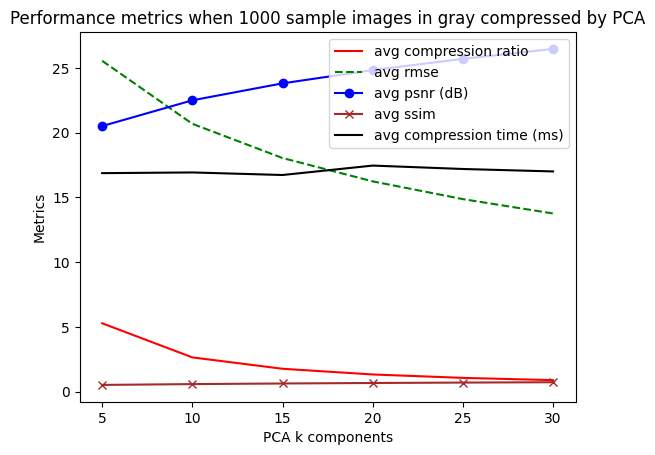

In [22]:
ks = [5, 10, 15, 20, 25, 30]
avg_compression_ratios = []
avg_rmses = []
avg_psnrs = []
avg_ssims = []
avg_mss = []

for k in ks:
    avg_compression_ratio, avg_rmse, avg_psnr, avg_ssim, avg_ms = pca_compress_gray_1000(k)
    avg_compression_ratios.append(avg_compression_ratio)
    avg_rmses.append(avg_rmse)
    avg_psnrs.append(avg_psnr)
    avg_ssims.append(avg_ssim)
    avg_mss.append(avg_ms)

# Plotting multiple lines
plt.plot(ks, avg_compression_ratios, label='avg compression ratio', color='red')
plt.plot(ks, avg_rmses, label='avg rmse', color='green', linestyle='--')
plt.plot(ks, avg_psnrs, label='avg psnr (dB)', color='blue', marker='o')
plt.plot(ks, avg_ssims, label='avg ssim', color='brown', marker='x')
plt.plot(ks, avg_mss, label='avg compression time (ms)', color='black')

# Adding title and labels
plt.title('Performance metrics when 1000 sample images in gray compressed by PCA')
plt.xlabel('PCA k components')
plt.ylabel('Metrics')

# Add legend
plt.legend()

# Show plot
plt.show()